In [ ]:
import numpy as np
import pandas as pd
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Mean center
    vectors1 = vectors1 - vectors1.mean(axis=0, keepdims=True)
    vectors2 = vectors2 - vectors2.mean(axis=0, keepdims=True)

    # Normalize each vector to unit length
    vectors1 = vectors1 / np.linalg.norm(vectors1, axis=1, keepdims=True)
    vectors2 = vectors2 / np.linalg.norm(vectors2, axis=1, keepdims=True)
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
    
    return df

# Define input directory where models are stored
input_dir = "models/chunk_2"
# Define output directory
output_dir = "output/chunk_1"
os.makedirs(output_dir, exist_ok=True)

# Define all pairs and periods to compare
subreddit_pairs = [
    ("republican", "democrats"),
    ("republican", "conservative"),
    ("democrats", "conservative"),
]
periods = ["before_2016", "2017_2020", "2021_2024"]

# Load all models into a dict for easy access
model_names = ["democrats", "republican", "conservative"]
models = {}
for name in model_names:
    models[name] = {}
    for period in periods:
        models[name][period] = gensim.models.Word2Vec.load(f"{input_dir}/{name}_{period}.model")

# Compare all pairs for all periods and save results
for sub1, sub2 in subreddit_pairs:
    for period in periods:
        output_file = f"{output_dir}/{sub1}_{sub2}_{period}.csv"
        compare_subreddit_embeddings_by_period(
            models[sub1][period],
            models[sub2][period],
            sub1,
            sub2,
            period,
            output_file=output_file
        )

print(f"Results saved to {output_dir}")
print("\nAnalysis complete.")


Comparing models:
before_2016: Common vocabulary between republican and democrats: 17891 words
Results saved to output/final_chunk/republican_democrats_before_2016.csv
before_2016: Common vocabulary between republican and conservative: 29715 words
Results saved to output/final_chunk/republican_conservative_before_2016.csv
before_2016: Common vocabulary between democrats and conservative: 19596 words
Results saved to output/final_chunk/democrats_conservative_before_2016.csv
2017_2020: Common vocabulary between republican and democrats: 24719 words
Results saved to output/final_chunk/republican_democrats_2017_2020.csv
2017_2020: Common vocabulary between republican and conservative: 33123 words
Results saved to output/final_chunk/republican_conservative_2017_2020.csv
2017_2020: Common vocabulary between democrats and conservative: 31961 words
Results saved to output/final_chunk/democrats_conservative_2017_2020.csv
2021_2024: Common vocabulary between republican and democrats: 30366 word

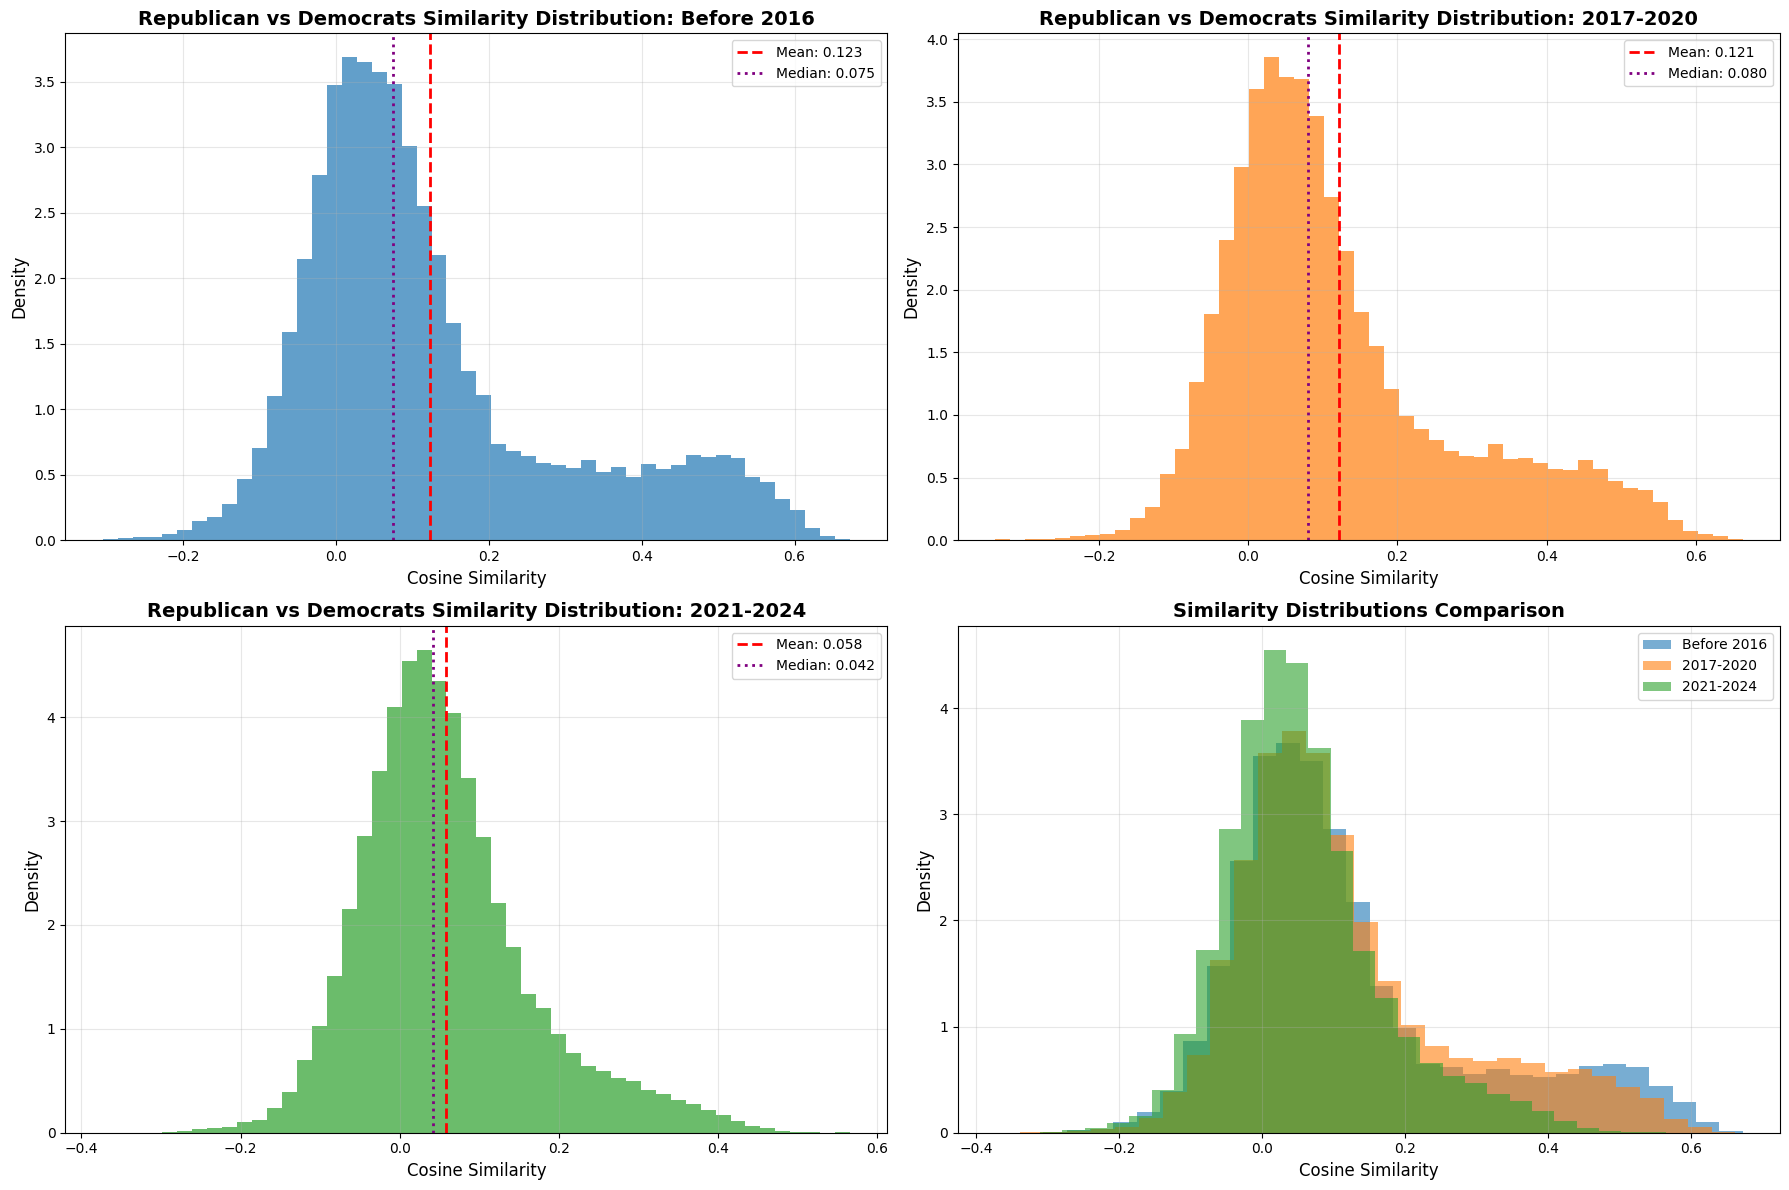

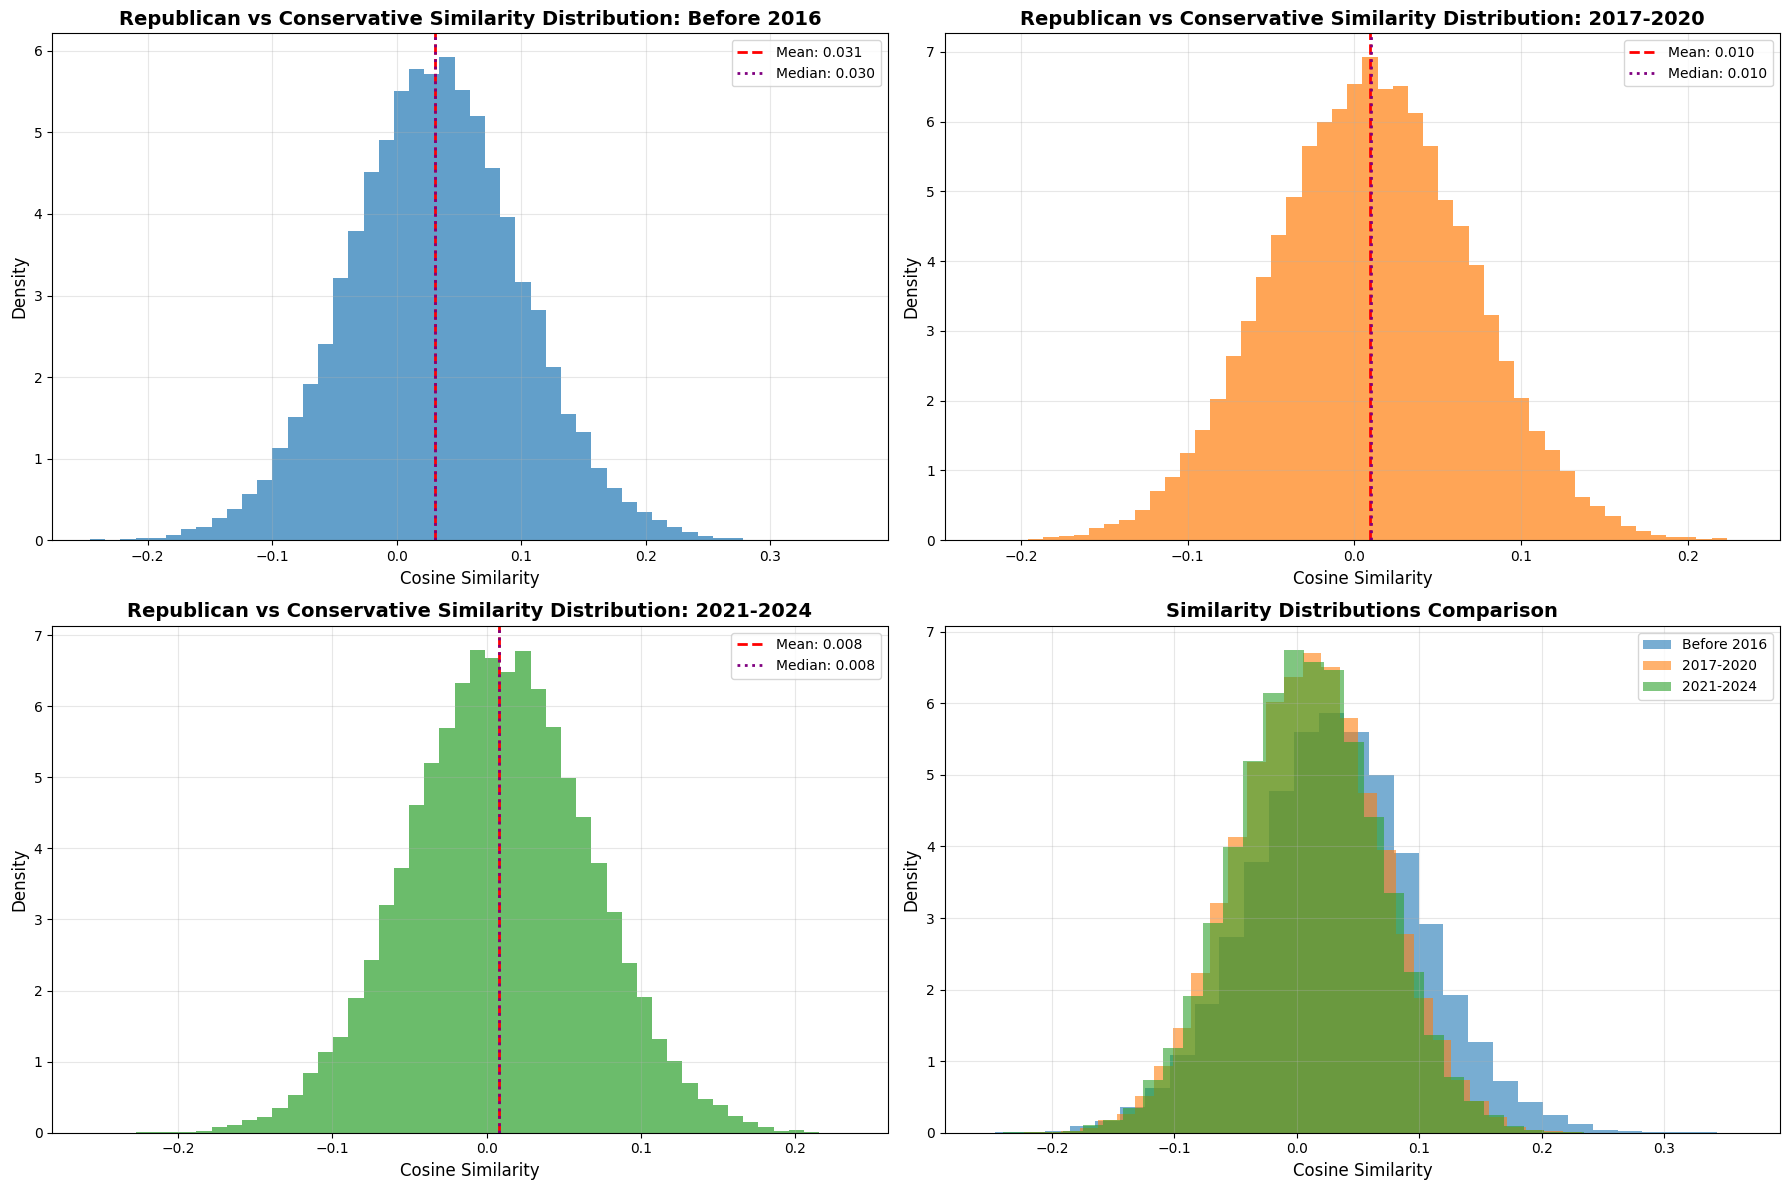

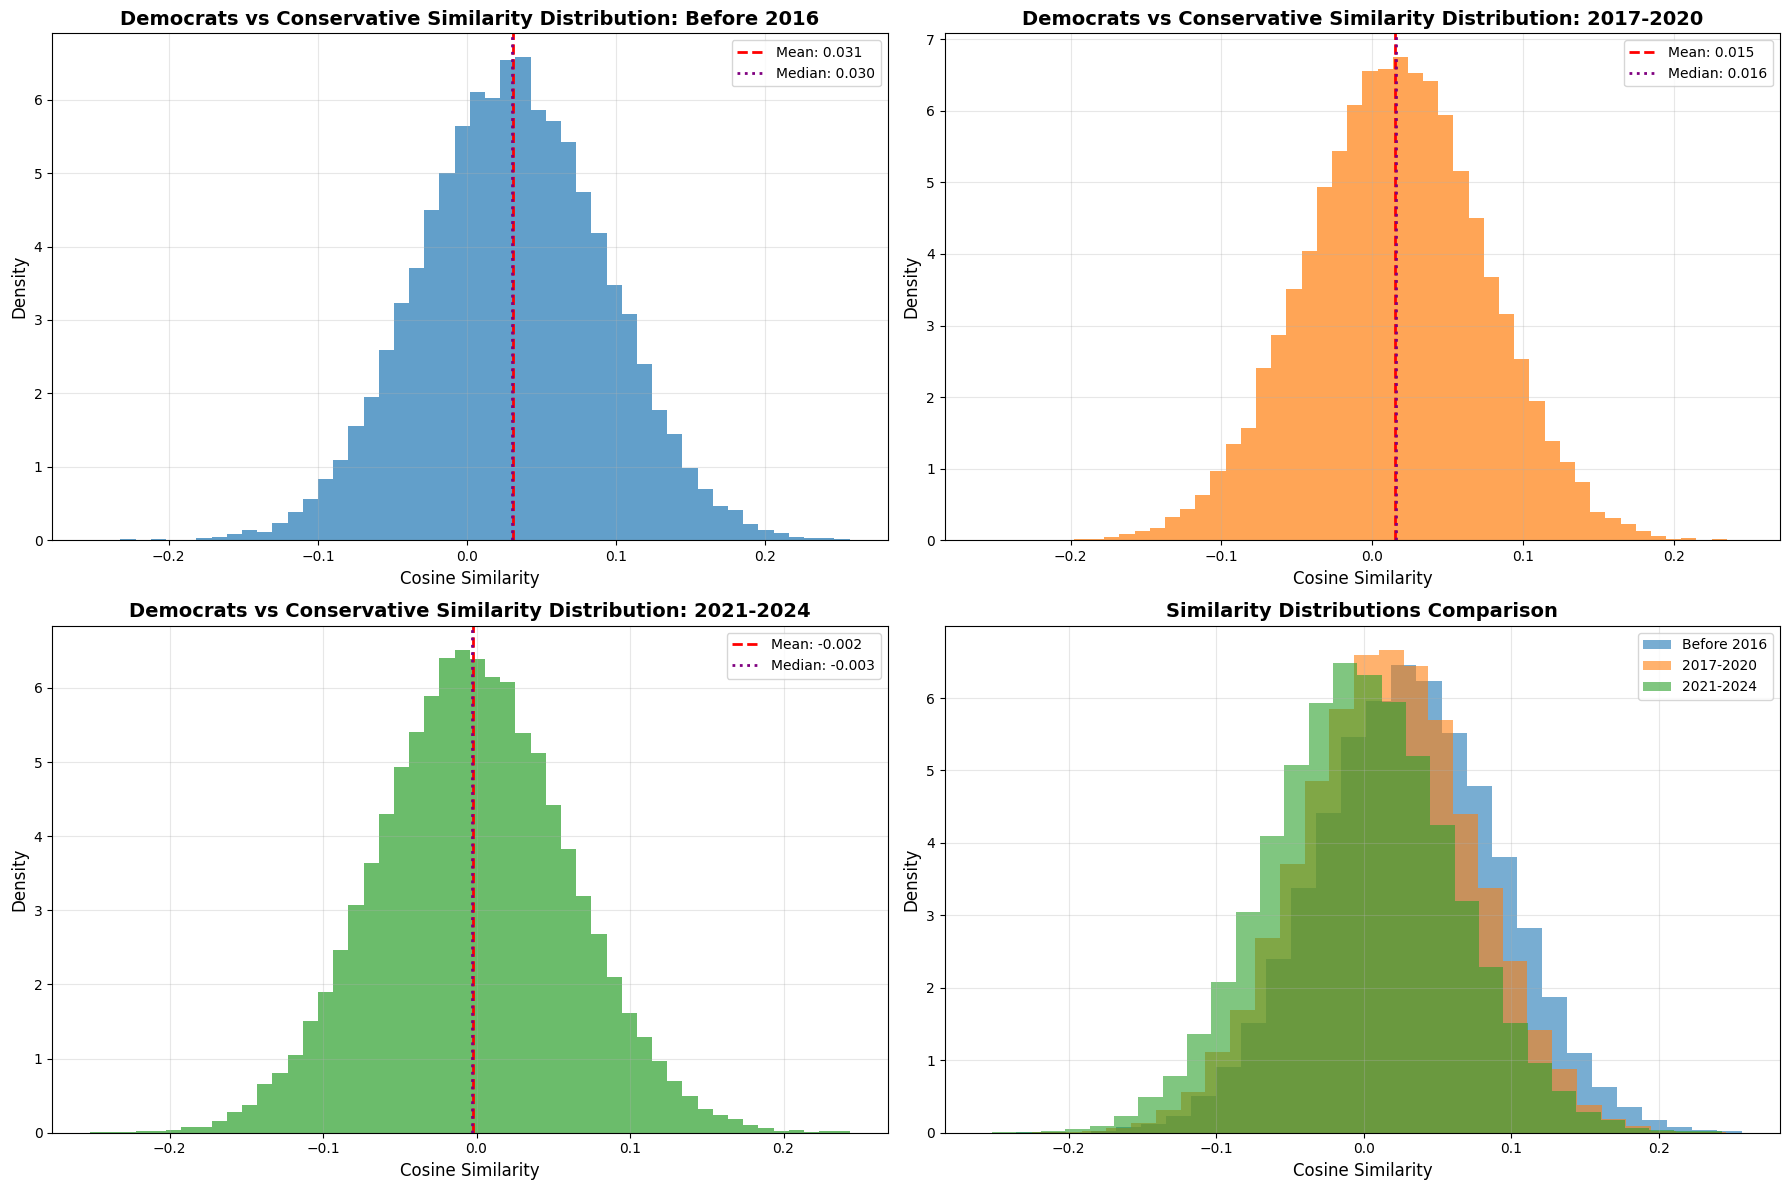

In [ ]:
def analyze_similarity_distributions(output_dir, df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()


input_dir = "output/chunk_1"
# Run the analysis
subreddit_pairs = [
    ("republican", "democrats"),
    ("republican", "conservative"),
    ("democrats", "conservative"),
]
periods = ["before_2016", "2017_2020", "2021_2024"]

for sub1, sub2 in subreddit_pairs:
    dfs = []
    for period in periods:
        csv_path = f"{input_dir}/{sub1}_{sub2}_{period}.csv"
        dfs.append(pd.read_csv(csv_path))
    analyze_similarity_distributions(
        input_dir,
        dfs[0], dfs[1], dfs[2],
        sub1.capitalize(), sub2.capitalize()
    )